In [3]:
from pyspark.sql import SQLContext
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
import utils
%matplotlib inline

In [5]:
sqlContext = SQLContext(sc)
dataset = sqlContext.read.load('/media/milad/Linux/bigdata/minute_weather.csv', 
                          format='com.databricks.spark.csv', 
                          header='true',inferSchema='true')

In [6]:
dataset.count()

1587257

In [10]:
filtere_dataset = dataset.filter((dataset.rowID % 10) == 0)
filtere_dataset.count()

158726

In [11]:
filtere_dataset.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
rowID,158726,793625.0,458203.9375103623,0,1587250
air_pressure,158726,916.8301614102414,3.0517165528314516,905.0,929.5
air_temp,158726,61.8515891536364,11.833569210641642,31.64,99.5
avg_wind_direction,158680,162.15610032770354,95.27820101905921,0.0,359.0
avg_wind_speed,158680,2.7752148979077447,2.0576239697426435,0.0,31.9
max_wind_direction,158680,163.46214393748426,92.45213853838722,0.0,359.0
max_wind_speed,158680,3.4005577262415194,2.418801620809888,0.1,36.0
min_wind_direction,158680,166.77401688933702,97.44110914784571,0.0,359.0
min_wind_speed,158680,2.134664103856878,1.742112505242437,0.0,31.6


In [12]:
filtere_dataset.filter(filtere_dataset.rain_accumulation == 0.0).count() 

157812

In [13]:
filtere_dataset.filter(filtere_dataset.rain_duration == 0.0).count() 

157237

In [14]:
drop_data = filtere_dataset.drop('rain_accumulation').drop('rain_duration').drop('hpwren_timestamp')

In [15]:
before = drop_data.count()
drop_data = drop_data.na.drop()
after = drop_data.count()
before - after

46

In [16]:
drop_data.columns

['rowID',
 'air_pressure',
 'air_temp',
 'avg_wind_direction',
 'avg_wind_speed',
 'max_wind_direction',
 'max_wind_speed',
 'min_wind_direction',
 'min_wind_speed',
 'relative_humidity']

In [18]:
featuresUsed = ['air_pressure', 'air_temp', 'avg_wind_direction', 'avg_wind_speed', 'max_wind_direction', 
        'max_wind_speed','relative_humidity']
assembler = VectorAssembler(inputCols=featuresUsed, outputCol="features_unscaled")
assembled = assembler.transform(drop_data)

In [21]:
scale = StandardScaler(inputCol="features_unscaled", outputCol="features", withStd=True, withMean=True)
scale_model = scale.fit(assembled)
scale_data = scale_model.transform(assembled)

In [23]:
scale_data = scale_data.select("features", "rowID")

elbow_set = scale_data.filter((scale_data.rowID % 3) == 0).select("features")
#elbow_set.persist()

In [25]:
clusters = range(2,31)
wsseList = utils.elbow(elbow_set, clusters)

Training for cluster size 2 
......................WSSE = 116135.32387397485 
Training for cluster size 3 
......................WSSE = 103408.96751787724 
Training for cluster size 4 
......................WSSE = 94577.2715128772 
Training for cluster size 5 
......................WSSE = 87993.31206982673 
Training for cluster size 6 
......................WSSE = 85084.84322949202 
Training for cluster size 7 
......................WSSE = 81552.63333229681 
Training for cluster size 8 
......................WSSE = 78828.61754551521 
Training for cluster size 9 
......................WSSE = 75645.1169422379 
Training for cluster size 10 
......................WSSE = 73172.41487329364 
Training for cluster size 11 
......................WSSE = 71394.824861575 
Training for cluster size 12 
......................WSSE = 69740.9866378799 
Training for cluster size 13 
......................WSSE = 69121.74608059169 
Training for cluster size 14 
......................WSSE = 67363.6887225043

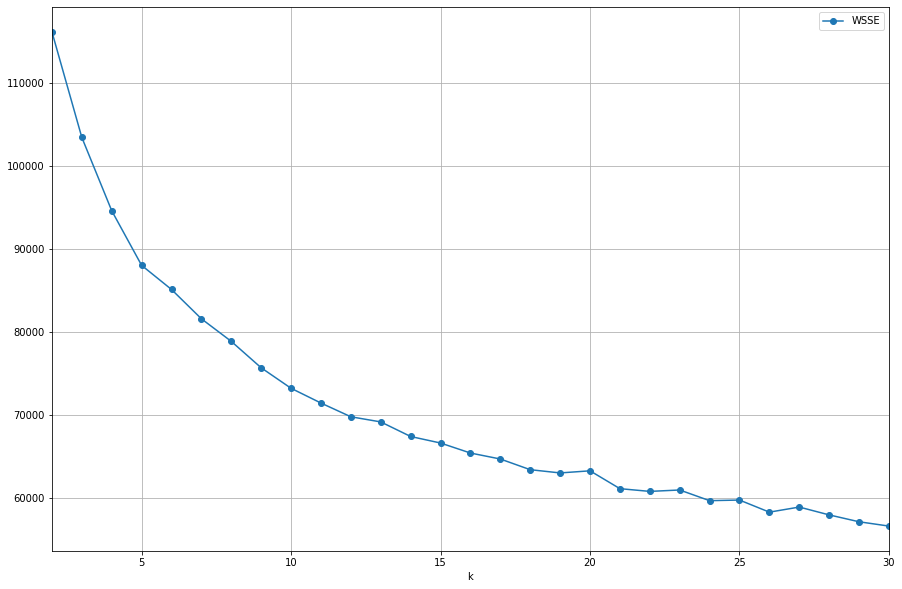

In [26]:
utils.elbow_plot(wsseList, clusters)

In [31]:
scale_data = scale_data.select("features")
scale_data.persist()

DataFrame[features: vector]

In [32]:
kmeans = KMeans(k=12, seed=1)
model = kmeans.fit(scale_data)
transformed = model.transform(scale_data)

In [33]:
centers = model.clusterCenters()
centers

[array([ 0.41826309, -0.96510345,  0.68753921, -0.53403506,  0.88343796,
        -0.51491771,  1.06076072]),
 array([-1.43480415, -1.42335186,  0.38846525,  2.04726263,  0.49984068,
         2.01879457,  1.50867362]),
 array([-0.15765726,  0.8559352 , -1.31392127, -0.57572746, -1.17179772,
        -0.59127424, -0.64347904]),
 array([-0.76485191, -0.14951347,  0.44030663,  1.52634387,  0.52540872,
         1.45669696,  0.25250959]),
 array([ 0.04450616, -0.77286581, -1.19290024, -0.57087666, -1.03928454,
        -0.58545772,  0.87001257]),
 array([-0.29459984,  0.55716351,  0.16449977, -0.69197671,  0.34642756,
        -0.70503003, -0.37859364]),
 array([-0.01266104,  0.74476735,  0.41890048,  0.43667096,  0.53499934,
         0.3957488 , -0.27520116]),
 array([-0.85576944, -1.12741402,  0.36855902,  0.16446897,  0.47050825,
         0.15435228,  1.34560317]),
 array([ 1.1813546 , -0.24902977, -1.15588283,  2.11410139, -1.05407922,
         2.23074143, -1.13306251]),
 array([ 1.41370016